# BPNet Vignette

Model predictions to show bias correction at a CTCF locus (Ins2)..

**Inputs**:
1. Bias model
2. Bigwigs of tn5 insertions for each cell state
3. Bigwigs of predictions w and wo bias
4. Bigwigs of importance scores

In [ ]:
import keras
import pyfaidx
import math
import pandas as pd
import tqdm
import numpy as np
import pyBigWig
import scipy
from modisco.visualization import viz_sequence
import keras.backend as K
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import sys
from pathlib import Path
from collections import defaultdict

In [69]:
from keras.utils import CustomObjectScope

# mtbatchgen
sys.path.append("/users/surag/kundajelab/chrombpnet-lite/src/")
from utils.loss import multinomial_nll
from utils import one_hot

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [ ]:
import shap
from utils.shap_utils import *

## Load Input Data

In [5]:
# "old" cluster IDs
CELL_STATES = [1,11,8]

In [7]:
MODEL_BASE = "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/"

In [8]:
BIGWIG_BASE = "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/bigwigs/cluster_idx{}.bw"
PRED_BIGWIG_BASE = MODEL_BASE + "/cluster_idx{}/predict/cluster_idx{}_w_bias.bw"
PRED_WO_BIAS_BIGWIG_BASE = MODEL_BASE + "/cluster_idx{}/predict/cluster_idx{}_wo_bias.bw"
IMP_BIGWIG_BASE = MODEL_BASE + "/cluster_idx{}/interpret/bigwig/counts.importance.bw"

In [9]:
bigwigs = dict()
pred_bigwigs = dict()
pred_wo_bias_bigwigs = dict()
imp_bigwigs = dict()

for x in CELL_STATES:
    bigwigs[x] = pyBigWig.open(BIGWIG_BASE.format(x))
    pred_bigwigs[x] = pyBigWig.open(PRED_BIGWIG_BASE.format(x, x))
    pred_wo_bias_bigwigs[x] = pyBigWig.open(PRED_WO_BIAS_BIGWIG_BASE.format(x, x))
    imp_bigwigs[x] = pyBigWig.open(IMP_BIGWIG_BASE.format(x, x))

In [71]:
# also need to plot bias predictions
# using any and will scale counts with that of the given cell type

with CustomObjectScope({'multinomial_nll': multinomial_nll}):
    model_paths = list(Path(MODEL_BASE).glob("cluster_idx{}/*.h5".format(1)))
    assert(len(model_paths)==2)

    bias_model_path = str([x for x in model_paths if "adjusted" in str(x)][0])
    model_path = str([x for x in model_paths if "adjusted" not in str(x)][0])

    bias_model = keras.models.load_model(bias_model_path)

In [10]:
hg38 = pyfaidx.Fasta('/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta')

In [11]:
MODEL_INP_LEN, MODEL_OUT_LEN = 2000,2000

In [12]:
def softmax(x):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(norm_x)/np.sum(np.exp(norm_x), axis=1, keepdims=True)

### Get normalization stats

For base-resolution predictions:

In [47]:
pred_upper_lims = dict()
    
for i in CELL_STATES:
    with open(MODEL_BASE + "cluster_idx{}/predict/cluster_idx{}_w_bias.stats.txt".format(i,i)) as f:
        d = [x.strip() for x in f]

        upper = [x for x in d if x.startswith("99.9%")]
        assert(len(upper)==1)
        upper = float(upper[0].split('\t')[1])
        
        pred_upper_lims[i] = upper

In [40]:
pred_upper_lims

{1: 13.96926, 11: 1.487253, 8: 12.106131}

In [45]:
pred_wo_bias_upper_lims = dict()
    
for i in CELL_STATES:
    with open(MODEL_BASE + "cluster_idx{}/predict/cluster_idx{}_wo_bias.stats.txt".format(i,i)) as f:
        d = [x.strip() for x in f]

        upper = [x for x in d if x.startswith("99.9%")]
        assert(len(upper)==1)
        upper = float(upper[0].split('\t')[1])
        
        pred_wo_bias_upper_lims[i] = upper

In [42]:
pred_wo_bias_upper_lims

{1: 11.830973, 11: 0.893731, 8: 9.155364}

In [24]:
# use this if quantile required is present 

explain_upper_lims = dict()
explain_lower_lims = dict()
    
for i in CELL_STATES:
    with open(MODEL_BASE + "cluster_idx{}/interpret/bigwig/counts.importance.stats.txt".format(i)) as f:
        d = [x.strip() for x in f]

        upper = [x for x in d if x.startswith("99.95%")]
        assert(len(upper)==1)
        upper = float(upper[0].split('\t')[1])
        
        lower = [x for x in d if ".1%" in x]
        assert(len(lower)==1)
        lower = float(lower[0].split('\t')[1])

        explain_upper_lims[i] = upper
        explain_lower_lims[i] = lower

In [25]:
explain_lower_lims

{1: -0.033098, 11: -0.028583, 8: -0.02697}

In [26]:
explain_upper_lims

{1: 0.213128, 11: 0.127204, 8: 0.175611}

For actual insertions:

In [22]:
# SMOOTH_SIGMA=2

In [28]:
insertions_upper_lims = dict()
# insertions_smoothed_upper_lims = dict()
insertions_log_cts_median = dict()

Q = 0.9995
S = 1000

for i in CELL_STATES:
    peaks = pd.read_csv("/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/data/20210818_n62599/peaks/overlap_merged/cluster_idx{}.bed".format(i),
               sep='\t', names=['chr','start','end','x1','x2','x3','x4','x5','x6','summit'])
    
    peaks = peaks.sample(S)
    
    vals = np.zeros((S, MODEL_OUT_LEN))
    j = 0
    for _,x in tqdm.tqdm(peaks.iterrows()):
        vals[j] = np.nan_to_num(bigwigs[i].values(x['chr'],
                                                  x['summit']+x['start'] - MODEL_OUT_LEN//2,
                                                  x['summit']+x['start'] + MODEL_OUT_LEN//2))
        j+=1

    print(vals.shape)

    insertions_upper_lims[i] = np.quantile(vals, Q)
    insertions_log_cts_median[i] = np.median(np.log(np.sum(vals, -1)))
#     insertions_smoothed_upper_lims[i] = np.quantile(scipy.ndimage.gaussian_filter1d(vals, SMOOTH_SIGMA),
#                                                    Q)

1000it [00:10, 93.58it/s]


(1000, 2000)


1000it [00:10, 98.44it/s]


(1000, 2000)


1000it [00:13, 73.40it/s]


(1000, 2000)


In [29]:
insertions_log_cts_median

{1: 6.758091806533841, 11: 5.043425116919247, 8: 6.541750979848354}

In [30]:
insertions_upper_lims

{1: 100.0, 11: 12.0, 8: 84.0}

## Rough Plot (Proper plotting in R)

In [32]:
LOC_CHR="chr12"
LOC_CENTER = 7807055
GENE = "Ins2"

# LEFTY1 enh chr1:225899430
# LIN28A prom chr1:26410794
# CDH1 prom chr16:68737277

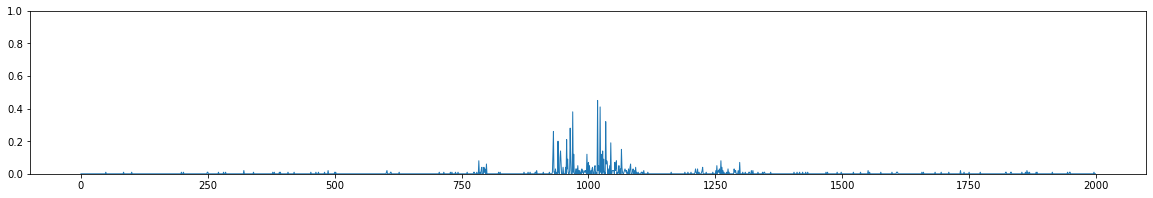

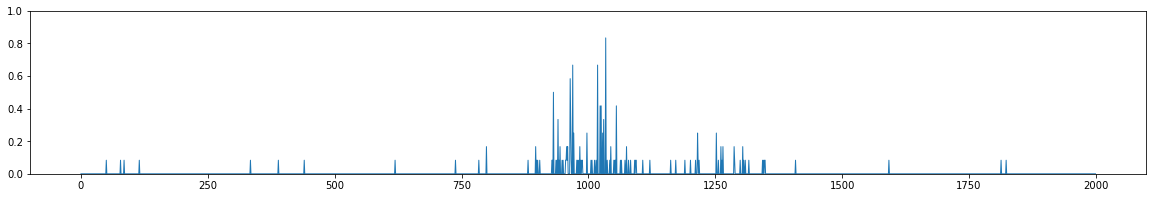

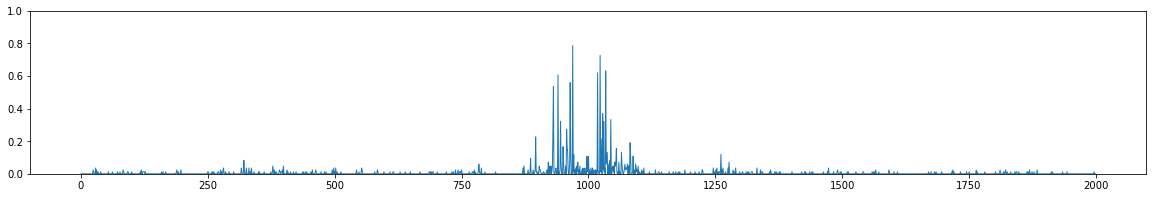

In [48]:
plt.rcParams["figure.figsize"] = (20,3)

for x in CELL_STATES:
    vals = np.nan_to_num(bigwigs[x].values(LOC_CHR, LOC_CENTER-(MODEL_OUT_LEN)//2,  LOC_CENTER+(MODEL_OUT_LEN//2)))
    
#     plt.plot(range(MODEL_OUT_LEN), scipy.ndimage.gaussian_filter1d(vals, SMOOTH_SIGMA)/insertions_smoothed_upper_lims[x])
#     plt.ylim(0, 1)
    
    plt.plot(range(MODEL_OUT_LEN), vals/insertions_upper_lims[x], linewidth=1)
    plt.ylim(0, 1)
    
    plt.show()

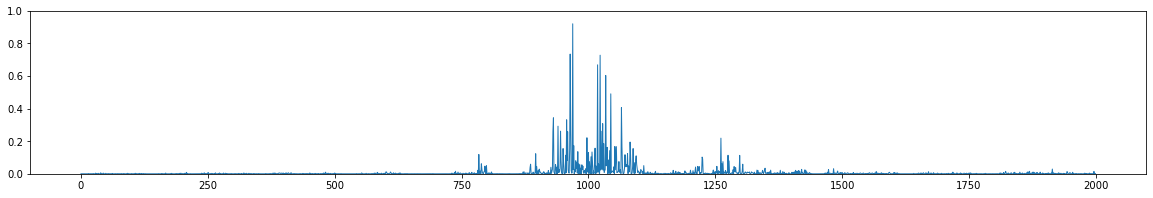

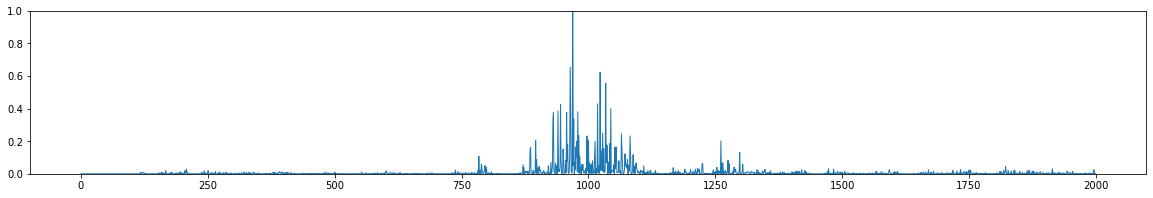

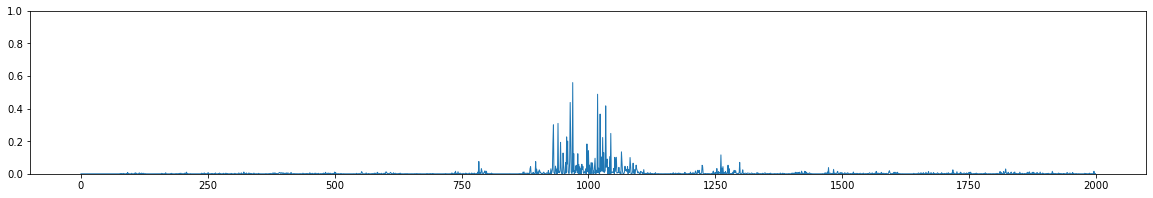

In [49]:
# model preds
seq = hg38[LOC_CHR][LOC_CENTER-(MODEL_INP_LEN)//2:LOC_CENTER+(MODEL_INP_LEN)//2]
seq = one_hot.dna_to_one_hot([str(seq)])

for x in CELL_STATES:
    vals = np.nan_to_num(pred_bigwigs[x].values(LOC_CHR, LOC_CENTER-(MODEL_OUT_LEN)//2,  LOC_CENTER+(MODEL_OUT_LEN//2)))

    plt.plot(range(MODEL_OUT_LEN), vals.ravel()/pred_upper_lims[x], linewidth=1)
    plt.ylim(0, 1)
    
#     plt.plot(range(MODEL_OUT_LEN), scipy.ndimage.gaussian_filter1d(prof.ravel()/pred_upper_lims[x], 
#                                                                    SMOOTH_SIGMA))
#     plt.ylim(0, 1)
    
    plt.show()   

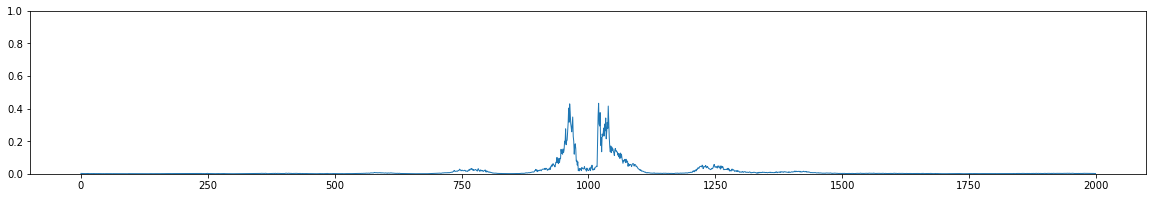

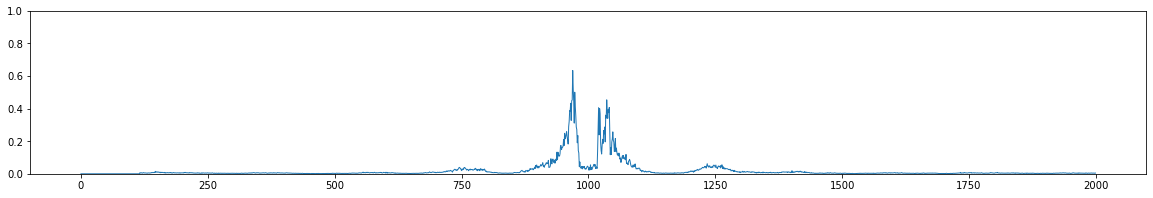

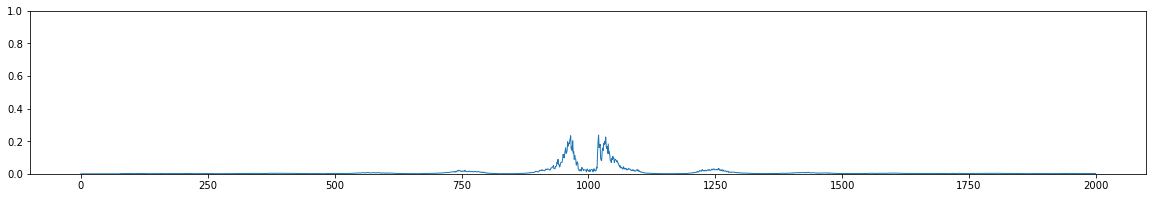

In [50]:
# model preds_wo_bias
seq = hg38[LOC_CHR][LOC_CENTER-(MODEL_INP_LEN)//2:LOC_CENTER+(MODEL_INP_LEN)//2]
seq = one_hot.dna_to_one_hot([str(seq)])

for x in CELL_STATES:
    vals = np.nan_to_num(pred_wo_bias_bigwigs[x].values(LOC_CHR, LOC_CENTER-(MODEL_OUT_LEN)//2,  LOC_CENTER+(MODEL_OUT_LEN//2)))

    plt.plot(range(MODEL_OUT_LEN), vals.ravel()/pred_wo_bias_upper_lims[x], linewidth=1)
    plt.ylim(0, 1)
    
#     plt.plot(range(MODEL_OUT_LEN), scipy.ndimage.gaussian_filter1d(prof.ravel()/pred_upper_lims[x], 
#                                                                    SMOOTH_SIGMA))
#     plt.ylim(0, 1)
    
    plt.show()   

array([1.0336875e-04, 4.6165162e-05, 1.1908205e-05, ..., 5.0697860e-04,
       2.9623718e-04, 3.8331273e-04], dtype=float32)

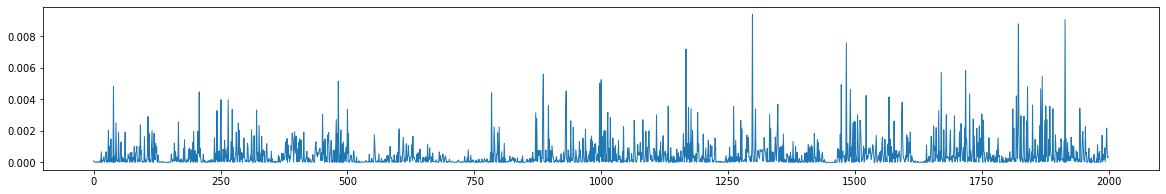

In [80]:
# bias_only
vals = softmax(bias_model.predict(seq)[0]).ravel()

plt.plot(range(MODEL_OUT_LEN), vals, linewidth=1)
# plt.ylim(0, 1)
    
#     plt.plot(range(MODEL_OUT_LEN), scipy.ndimage.gaussian_filter1d(prof.ravel()/pred_upper_lims[x], 
#                                                                    SMOOTH_SIGMA))
#     plt.ylim(0, 1)
    
plt.show()   

In [51]:
for x in CELL_STATES:
    vals = np.nan_to_num(bigwigs[x].values(LOC_CHR, LOC_CENTER-(MODEL_OUT_LEN)//2,  LOC_CENTER+(MODEL_OUT_LEN//2)))
    vals_norm = vals.ravel()/insertions_upper_lims[x]
    
    print((np.log(np.sum(vals))) - (insertions_log_cts_median[x]-insertions_log_cts_median[1]))

6.733401891837359
6.890816422188423
7.430109134804129


Write to csv file to plot in R.

In [82]:
f = open("./Supp/Ins2_vignette_intermediate/{}.{}.{}.bias.pred.softmax.tsv".format(GENE, LOC_CHR, LOC_CENTER), "w")

vals = softmax(bias_model.predict(seq)[0]).ravel()
f.write('\t'.join([str(x) for x in vals]))
f.close()

In [53]:
f = open("./Supp/Ins2_vignette_intermediate/{}.{}.{}.insertions.unsmoothed.tsv".format(GENE, LOC_CHR, LOC_CENTER), "w")

f.write("\t".join(["cluster_idx", "total_adjusted_cts"] + [str(x) for x in list(range(1,MODEL_OUT_LEN+1))]) + "\n")

for x in CELL_STATES:
    vals = np.nan_to_num(bigwigs[x].values(LOC_CHR, LOC_CENTER-(MODEL_OUT_LEN)//2,  LOC_CENTER+(MODEL_OUT_LEN//2)))
    vals_norm = vals.ravel()/insertions_upper_lims[x]
    log_cts_norm = np.log(np.sum(vals)) - (insertions_log_cts_median[x]-insertions_log_cts_median[1])
    
    f.write('\t'.join([str(x), str(log_cts_norm)] + [str(y) for y in vals_norm]) + '\n')
    
#     plt.plot(range(MODEL_OUT_LEN), scipy.ndimage.gaussian_filter1d(vals, SMOOTH_SIGMA))
#     plt.ylim(0, insertions_smoothed_upper_lims[x])
f.close()

In [55]:
f = open("./Supp/Ins2_vignette_intermediate/{}.{}.{}.pred.unsmoothed.tsv".format(GENE, LOC_CHR, LOC_CENTER), "w")

f.write("\t".join(["cluster_idx"] + [str(x) for x in list(range(1,MODEL_OUT_LEN+1))]) + "\n")

for x in CELL_STATES:
#     bias_prof, bias_cts = bias_models[x].predict(seq)
    vals = np.nan_to_num(pred_bigwigs[x].values(LOC_CHR, LOC_CENTER-(MODEL_OUT_LEN)//2,  LOC_CENTER+(MODEL_OUT_LEN//2)))
    
    vals_norm = vals.ravel()/pred_upper_lims[x]

#     log_cts_norm = cts[0][0]  + (pred_log_cts_median[1] - pred_log_cts_median[x])
    
    f.write('\t'.join([str(x)] + [str(y) for y in vals_norm]) + '\n')
    
#     plt.plot(range(MODEL_OUT_LEN), scipy.ndimage.gaussian_filter1d(vals, SMOOTH_SIGMA))
#     plt.ylim(0, insertions_smoothed_upper_lims[x])
f.close()

In [56]:
f = open("./Supp/Ins2_vignette_intermediate/{}.{}.{}.pred.wo_bias.unsmoothed.tsv".format(GENE, LOC_CHR, LOC_CENTER), "w")

f.write("\t".join(["cluster_idx"] + [str(x) for x in list(range(1,MODEL_OUT_LEN+1))]) + "\n")

for x in CELL_STATES:
#     bias_prof, bias_cts = bias_models[x].predict(seq)
    vals = np.nan_to_num(pred_wo_bias_bigwigs[x].values(LOC_CHR, LOC_CENTER-(MODEL_OUT_LEN)//2,  LOC_CENTER+(MODEL_OUT_LEN//2)))
    
    vals_norm = vals.ravel()/pred_wo_bias_upper_lims[x]

#     log_cts_norm = cts[0][0]  + (pred_log_cts_median[1] - pred_log_cts_median[x])
    
    f.write('\t'.join([str(x)] + [str(y) for y in vals_norm]) + '\n')
    
#     plt.plot(range(MODEL_OUT_LEN), scipy.ndimage.gaussian_filter1d(vals, SMOOTH_SIGMA))
#     plt.ylim(0, insertions_smoothed_upper_lims[x])
f.close()

## Explanations

array([ 0.        ,  0.        ,  0.        , ...,  0.00016521,
       -0.00071707,  0.00045232])

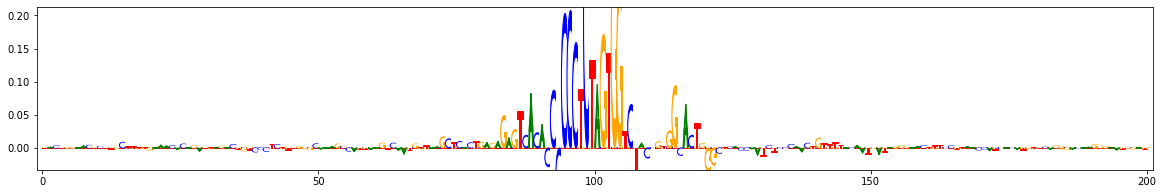

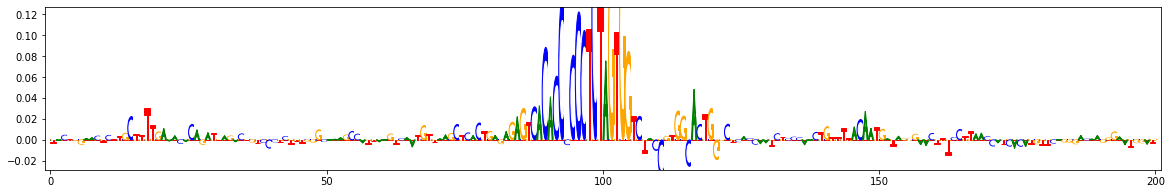

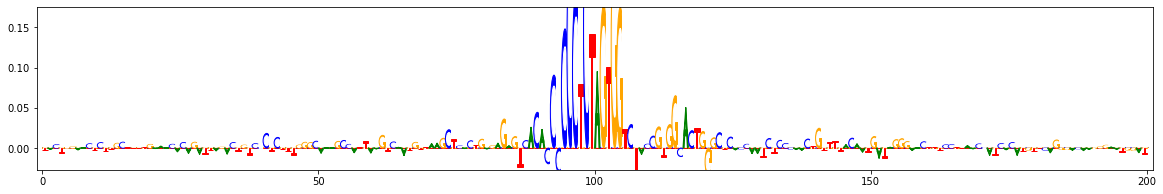

In [60]:
SLICE_START=900
SLICE_END=1100

for x in CELL_STATES:
    scores = np.nan_to_num(imp_bigwigs[x].values(LOC_CHR, LOC_CENTER-(MODEL_OUT_LEN)//2,  LOC_CENTER+(MODEL_OUT_LEN//2))).ravel()
    
    projected_shap_scores = seq[0] * np.expand_dims(scores,1)
    
    fig, ax = plt.subplots()
    viz_sequence.plot_weights_given_ax(ax, projected_shap_scores[SLICE_START:SLICE_END], 
                                       subticks_frequency=50,
                                      figsize=(10,3))
#     plt.plot(projected_shap_scores[0])
    ax.set_ylim(explain_lower_lims[x], explain_upper_lims[x])
    plt.show()

In [61]:
projected_shap_scores[projected_shap_scores!=0].shape

(1922,)

In [67]:
f = open("./Supp/Ins2_vignette_intermediate/{}.{}.{}.counts.explain.tsv".format(GENE, LOC_CHR, LOC_CENTER), "w")

f.write("\t".join(["cluster_idx", "lower_lim", "upper_lim"] + [str(x) for x in list(range(1,MODEL_OUT_LEN+1))]) + "\n")

for x in CELL_STATES:
    projected_shap_scores = np.nan_to_num(imp_bigwigs[x].values(LOC_CHR, LOC_CENTER-(MODEL_OUT_LEN)//2,  LOC_CENTER+(MODEL_OUT_LEN//2))).ravel()
    
#     projected_shap_scores = seq[0] * np.expand_dims(scores,1)
    
    # slice to keep only out-len length
    mid = len(projected_shap_scores)//2
    projected_shap_scores = projected_shap_scores[mid-(MODEL_OUT_LEN//2):mid+(MODEL_OUT_LEN//2)]
    
    f.write('\t'.join([str(x), 
                       str(explain_lower_lims[x]),
                       str(explain_upper_lims[x])] + [str(y) for y in projected_shap_scores]) + '\n')
    
f.close()